In [ ]:
import glob
import argparse
import shutil


if __name__ == '__main__':
    inp_folder = '/kaggle/input/alpha-dent/AlphaDent' + '/'
    out_folder = '/kaggle/output/alpha-dent/AlphaDent_4_classes' + '/'

    shutil.copytree(inp_folder, out_folder)

    # Replace txt files
    txt_paths = glob.glob(out_folder + '**/*.txt', recursive=True)
    for txt_path in txt_paths:
        lines = open(txt_path).readlines()
        out = open(txt_path, 'w')
        for line in lines:
            if line[0] == '4' or line[0] == '5' or line[0] == '6' or line[0] == '7' or line[0] == '8':
                out.write('3' + line[1:])
            else:
                out.write(line)
        out.close()

    id_to_classes = {
        1: 'Abrasion',
        2: 'Filling',
        3: 'Crown',
        4: 'Caries',
    }

    # Create .yaml file
    out = open(out_folder + 'yolo_seg_train.yaml', 'w')
    out.write('path: {}\n'.format(out_folder))
    out.write('train: images/train\n')
    out.write('val: images/valid\n')
    out.write('names:\n')
    out.write('  0: Abrasion\n')
    out.write('  1: Filling\n')
    out.write('  2: Crown\n')
    out.write('  3: Caries\n')
    out.close()


print("Done")

In [20]:
import os
import sys
import time
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
import yaml
import random
from PIL import Image
import warnings

In [21]:
# Define original paths
BASE_PATH = '/kaggle/output/alpha-dent/AlphaDent_4_classes'
ORIGINAL_TRAIN_IMAGES_PATH = f'{BASE_PATH}/images/train'
VALID_IMAGES_PATH = f'{BASE_PATH}/images/valid'
TEST_IMAGES_PATH = f'{BASE_PATH}/images/test'
ORIGINAL_TRAIN_LABELS_PATH = f'{BASE_PATH}/labels/train'
VALID_LABELS_PATH = f'{BASE_PATH}/labels/valid'

# Output paths
OUTPUT_DIR = '/kaggle/working/'
WEIGHTS_DIR = f'{OUTPUT_DIR}/weights'
os.makedirs(WEIGHTS_DIR, exist_ok=True)

# Create new dataset structure with 90/10 split
NEW_DATASET_PATH = f'{OUTPUT_DIR}/alphadent_90_10_split'
NEW_TRAIN_IMAGES_PATH = f'{NEW_DATASET_PATH}/images/train'
NEW_EVAL_IMAGES_PATH = f'{NEW_DATASET_PATH}/images/eval'
NEW_VALID_IMAGES_PATH = f'{NEW_DATASET_PATH}/images/valid'
NEW_TEST_IMAGES_PATH = f'{NEW_DATASET_PATH}/images/test'
NEW_TRAIN_LABELS_PATH = f'{NEW_DATASET_PATH}/labels/train'
NEW_EVAL_LABELS_PATH = f'{NEW_DATASET_PATH}/labels/eval'
NEW_VALID_LABELS_PATH = f'{NEW_DATASET_PATH}/labels/valid'


In [24]:
import os
import sys
import time
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
import yaml
import random
from PIL import Image
import shutil
import warnings
warnings.filterwarnings('ignore')

# Disable wandb
os.environ['WANDB_DISABLED'] = 'true'

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Install required packages
print("Installing required packages...")
os.system('pip install -q ultralytics')

import torch
from ultralytics import YOLO

# Set deterministic behavior for PyTorch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f'\nPyTorch Version: {torch.__version__}')
print(f'CUDA Available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'CUDA Device: {torch.cuda.get_device_name(0)}')

# Define original paths
BASE_PATH = '/kaggle/output/alpha-dent/AlphaDent_4_classes'
ORIGINAL_TRAIN_IMAGES_PATH = f'{BASE_PATH}/images/train'
VALID_IMAGES_PATH = f'{BASE_PATH}/images/valid'
TEST_IMAGES_PATH = f'{BASE_PATH}/images/test'
ORIGINAL_TRAIN_LABELS_PATH = f'{BASE_PATH}/labels/train'
VALID_LABELS_PATH = f'{BASE_PATH}/labels/valid'

# Output paths
OUTPUT_DIR = '/kaggle/working/'
WEIGHTS_DIR = f'{OUTPUT_DIR}/weights'
os.makedirs(WEIGHTS_DIR, exist_ok=True)

# Create new dataset structure with 90/10 split
NEW_DATASET_PATH = f'{OUTPUT_DIR}/alphadent_90_10_split'
NEW_TRAIN_IMAGES_PATH = f'{NEW_DATASET_PATH}/images/train'
NEW_EVAL_IMAGES_PATH = f'{NEW_DATASET_PATH}/images/eval'
NEW_VALID_IMAGES_PATH = f'{NEW_DATASET_PATH}/images/valid'
NEW_TEST_IMAGES_PATH = f'{NEW_DATASET_PATH}/images/test'
NEW_TRAIN_LABELS_PATH = f'{NEW_DATASET_PATH}/labels/train'
NEW_EVAL_LABELS_PATH = f'{NEW_DATASET_PATH}/labels/eval'
NEW_VALID_LABELS_PATH = f'{NEW_DATASET_PATH}/labels/valid'

# Create directories
os.makedirs(NEW_TRAIN_IMAGES_PATH, exist_ok=True)
os.makedirs(NEW_EVAL_IMAGES_PATH, exist_ok=True)
os.makedirs(NEW_VALID_IMAGES_PATH, exist_ok=True)
os.makedirs(NEW_TEST_IMAGES_PATH, exist_ok=True)
os.makedirs(NEW_TRAIN_LABELS_PATH, exist_ok=True)
os.makedirs(NEW_EVAL_LABELS_PATH, exist_ok=True)
os.makedirs(NEW_VALID_LABELS_PATH, exist_ok=True)

print("\n=== Creating 90/10 Train/Eval Split ===")

# Get all training images
original_train_images = sorted(glob.glob(f'{ORIGINAL_TRAIN_IMAGES_PATH}/*.jpg'))
print(f"Total original training images: {len(original_train_images)}")

# Shuffle and split into 90% train, 10% eval
random.shuffle(original_train_images)
split_idx = int(0.9 * len(original_train_images))
train_90_images = original_train_images[:split_idx]
eval_10_images = original_train_images[split_idx:]

print(f"90% for training: {len(train_90_images)}")
print(f"10% for evaluation: {len(eval_10_images)}")

def copy_files(image_list, dest_images_dir, dest_labels_dir, source_labels_dir, desc):
    """Copy images and corresponding labels to destination directories."""
    for img_path in tqdm(image_list, desc=desc):
        # Copy image
        img_filename = os.path.basename(img_path)
        shutil.copy2(img_path, os.path.join(dest_images_dir, img_filename))
        
        # Copy corresponding label
        label_filename = img_filename.replace('.jpg', '.txt')
        source_label_path = os.path.join(source_labels_dir, label_filename)
        dest_label_path = os.path.join(dest_labels_dir, label_filename)
        
        if os.path.exists(source_label_path):
            shutil.copy2(source_label_path, dest_label_path)

# Copy 90% training data
copy_files(train_90_images, NEW_TRAIN_IMAGES_PATH, NEW_TRAIN_LABELS_PATH, 
          ORIGINAL_TRAIN_LABELS_PATH, "Copying 90% training data")

# Copy 10% evaluation data
copy_files(eval_10_images, NEW_EVAL_IMAGES_PATH, NEW_EVAL_LABELS_PATH, 
          ORIGINAL_TRAIN_LABELS_PATH, "Copying 10% evaluation data")

# Copy original validation data (unchanged)
original_valid_images = glob.glob(f'{VALID_IMAGES_PATH}/*.jpg')
copy_files(original_valid_images, NEW_VALID_IMAGES_PATH, NEW_VALID_LABELS_PATH, 
          VALID_LABELS_PATH, "Copying validation data")

# Copy test data (images only, no labels)
print("Copying test images...")
test_images = glob.glob(f'{TEST_IMAGES_PATH}/*.jpg')
for img_path in tqdm(test_images, desc="Copying test images"):
    img_filename = os.path.basename(img_path)
    shutil.copy2(img_path, os.path.join(NEW_TEST_IMAGES_PATH, img_filename))

# Define class information
CLASS_INFO = {
    0: {'name': 'Abrasion', 'description': 'Teeth with mechanical wear of hard tissues'},
    1: {'name': 'Filling', 'description': 'Dental fillings of various types'},
    2: {'name': 'Crown', 'description': 'Dental crown (restoration)'},
    3: {'name': 'Caries', 'description': 'Caries in fissures and pits'}
}

# Create YAML configuration for YOLO
print("\n=== Creating YOLO Configuration ===")
yolo_config = {
    'path': NEW_DATASET_PATH,
    'train': 'images/train',
    'val': 'images/valid',
    'test': 'images/test',
    'nc': 4,
    'names': [CLASS_INFO[i]['name'] for i in range(4)]
}

# Save the configuration
CUSTOM_YAML_PATH = f'{OUTPUT_DIR}/alphadent_config_90_10.yaml'
with open(CUSTOM_YAML_PATH, 'w') as f:
    yaml.dump(yolo_config, f, default_flow_style=False)
print(f"Created custom YAML config at: {CUSTOM_YAML_PATH}")

# Count images in new dataset
new_train_images = sorted(glob.glob(f'{NEW_TRAIN_IMAGES_PATH}/*.jpg'))
new_eval_images = sorted(glob.glob(f'{NEW_EVAL_IMAGES_PATH}/*.jpg'))
new_valid_images = sorted(glob.glob(f'{NEW_VALID_IMAGES_PATH}/*.jpg'))
new_test_images = sorted(glob.glob(f'{NEW_TEST_IMAGES_PATH}/*.jpg'))

print(f"\n=== New Dataset Statistics ===")
print(f"Training images (90%): {len(new_train_images)}")
print(f"Evaluation images (10%): {len(new_eval_images)}")
print(f"Validation images: {len(new_valid_images)}")
print(f"Test images: {len(new_test_images)}")

# Analyze class distribution
def analyze_class_distribution(labels_path, dataset_name):
    """Analyze class distribution in dataset."""
    class_counts = {i: 0 for i in range(4)}
    total_annotations = 0
    
    label_files = glob.glob(f'{labels_path}/*.txt')
    
    for label_file in tqdm(label_files, desc=f"Analyzing {dataset_name} labels", leave=False):
        if os.path.exists(label_file) and os.path.getsize(label_file) > 0:
            try:
                with open(label_file, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        if line.strip():
                            parts = line.strip().split()
                            if parts:
                                class_id = int(parts[0])
                                if 0 <= class_id < 4:
                                    class_counts[class_id] += 1
                                    total_annotations += 1
            except Exception:
                continue
    
    return class_counts, total_annotations

print("\n=== Analyzing Class Distribution ===")
train_class_counts, train_total = analyze_class_distribution(NEW_TRAIN_LABELS_PATH, "training")
eval_class_counts, eval_total = analyze_class_distribution(NEW_EVAL_LABELS_PATH, "evaluation")
valid_class_counts, valid_total = analyze_class_distribution(NEW_VALID_LABELS_PATH, "validation")

print(f"Training set (90%): {train_total} total annotations")
for i, (class_id, count) in enumerate(train_class_counts.items()):
    print(f"  {CLASS_INFO[class_id]['name']}: {count}")

print(f"Evaluation set (10%): {eval_total} total annotations")
for i, (class_id, count) in enumerate(eval_class_counts.items()):
    print(f"  {CLASS_INFO[class_id]['name']}: {count}")

print(f"Validation set: {valid_total} total annotations")

Installing required packages...

PyTorch Version: 2.6.0+cu124
CUDA Available: False

=== Creating 90/10 Train/Eval Split ===
Total original training images: 1237
90% for training: 1113
10% for evaluation: 124


Copying 90% training data:   0%|          | 0/1113 [00:00<?, ?it/s]

Copying 10% evaluation data:   0%|          | 0/124 [00:00<?, ?it/s]

Copying validation data:   0%|          | 0/83 [00:00<?, ?it/s]

Copying test images...


Copying test images:   0%|          | 0/135 [00:00<?, ?it/s]


=== Creating YOLO Configuration ===
Created custom YAML config at: /kaggle/working//alphadent_config_90_10.yaml

=== New Dataset Statistics ===
Training images (90%): 1113
Evaluation images (10%): 124
Validation images: 83
Test images: 135

=== Analyzing Class Distribution ===


Analyzing training labels:   0%|          | 0/1113 [00:00<?, ?it/s]

Analyzing evaluation labels:   0%|          | 0/124 [00:00<?, ?it/s]

Analyzing validation labels:   0%|          | 0/83 [00:00<?, ?it/s]

Training set (90%): 10892 total annotations
  Abrasion: 5369
  Filling: 1984
  Crown: 518
  Caries: 3021
Evaluation set (10%): 1140 total annotations
  Abrasion: 588
  Filling: 203
  Crown: 52
  Caries: 297
Validation set: 872 total annotations


In [ ]:

# Training configuration
print("\n=== Model Training Configuration ===")
EPOCHS = 30
IMAGE_SIZE = 640
BATCH_SIZE = 8 if torch.cuda.is_available() else 4
PATIENCE = 5

print(f"Epochs: {EPOCHS}")
print(f"Image Size: {IMAGE_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Early Stopping Patience: {PATIENCE}")

# Initialize and train model
print("\n=== Starting Model Training ===")
model = YOLO('yolov8x-seg.pt')

# Train the model with optimized parameters
results = model.train(
    data=CUSTOM_YAML_PATH,
    epochs=EPOCHS,
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    patience=PATIENCE,
    save=True,
    save_period=10,
    project=OUTPUT_DIR,
    name='alphadent_yolov8x_90_10',
    exist_ok=True,
    pretrained=True,
    optimizer='AdamW',
    lr0=0.001,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3.0,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,
    box=7.5,
    cls=0.5,
    dfl=1.5,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=0.0,
    translate=0.1,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    flipud=0.0,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.0,
    copy_paste=0.0,
    plots=True,
    device=0 if torch.cuda.is_available() else 'cpu',
    workers=2,
    verbose=True,
    amp=True,
    val=True
)

print("\nTraining completed!")


In [26]:
# Load best model
print("=== Loading Best Model ===")
best_model_path = f'{OUTPUT_DIR}/alphadent_yolov8x_90_10/weights/best.pt'
if os.path.exists(best_model_path):
    model = YOLO(best_model_path)
    print(f"Loaded best model from: {best_model_path}")
else:
    last_model_path = f'{OUTPUT_DIR}/alphadent_yolov8x_90_10/weights/last.pt'
    if os.path.exists(last_model_path):
        model = YOLO(last_model_path)
        print(f"Loaded last model from: {last_model_path}")
    else:
        print("Warning: No trained model found, using pretrained model")
        model = YOLO('yolov8x-seg.pt')

# Validate model on original validation set
print("\n=== Model Validation on Original Validation Set ===")
try:
    metrics = model.val(
        data=CUSTOM_YAML_PATH,
        imgsz=IMAGE_SIZE,
        batch=1,
        conf=0.001,
        iou=0.5,
        max_det=300,
        device=0 if torch.cuda.is_available() else 'cpu',
        plots=False,
        save_json=False,
    )
    
    print(f"\nValidation Results on Original Validation Set:")
    print(f"mAP@50: {metrics.seg.map50:.4f}")
    print(f"mAP@50-95: {metrics.seg.map:.4f}")
except Exception as e:
    print(f"Validation error (non-critical): {e}")

# Create custom YAML for evaluation on the 10% held-out data
eval_config = {
    'path': NEW_DATASET_PATH,
    'train': 'images/train',
    'val': 'images/eval',  # Point to eval set for validation
    'test': 'images/test',
    'nc': 4,
    'names': [CLASS_INFO[i]['name'] for i in range(4)]
}

EVAL_YAML_PATH = f'{OUTPUT_DIR}/alphadent_eval_config.yaml'
with open(EVAL_YAML_PATH, 'w') as f:
    yaml.dump(eval_config, f, default_flow_style=False)

# Evaluate model on the 10% held-out labeled data
print("\n=== Model Evaluation on 10% Held-out Labeled Data ===")
try:
    eval_metrics = model.val(
        data=EVAL_YAML_PATH,
        imgsz=IMAGE_SIZE,
        batch=1,
        conf=0.001,
        iou=0.5,
        max_det=300,
        device=0 if torch.cuda.is_available() else 'cpu',
        plots=True,
        save_json=True,
        name='eval_10_percent'
    )
    
    print(f"\nEvaluation Results on 10% Held-out Data:")
    print(f"mAP@50: {eval_metrics.seg.map50:.4f}")
    print(f"mAP@50-95: {eval_metrics.seg.map:.4f}")
    print(f"Per-class mAP@50:")
    for i, map_val in enumerate(eval_metrics.seg.maps):
        print(f"  {CLASS_INFO[i]['name']}: {map_val:.4f}")
        
except Exception as e:
    print(f"Evaluation error: {e}")

# Final summary
print("\n=== Summary ===")
print(f"✓ Successfully created 90/10 train/eval split")
print(f"✓ Trained model on 90% of original training data ({len(new_train_images)} images)")
print(f"✓ Evaluated model on 10% held-out labeled data ({len(new_eval_images)} images)")
print(f"✓ Also validated on original validation set ({len(new_valid_images)} images)")
print(f"✓ Model weights saved to: {OUTPUT_DIR}/alphadent_yolov8x_90_10/weights/")


=== Loading Best Model ===
Loaded best model from: /kaggle/working//alphadent_yolov8x_90_10/weights/best.pt

=== Model Validation on Original Validation Set ===
Ultralytics 8.3.199 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon CPU @ 2.20GHz)
YOLOv8x-seg summary (fused): 125 layers, 71,724,508 parameters, 0 gradients, 328.0 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3561.9±191.5 MB/s, size: 3132.4 KB)
val: Scanning /kaggle/working/alphadent_90_10_split/labels/valid.cache... 83 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 83/83 98.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 83/83 0.4it/s 3:332.6ss
                   all         83        872      0.671      0.671      0.695      0.496      0.657      0.666      0.681      0.444
              Abrasion         73        409      0.629      0.895      0.828      0.744       0.63      0.897      0.

In [ ]:
# =====================
# Train Faster R-CNN
# =====================
print("=== Training Faster R-CNN ===")

import glob, os
import torch
import torchvision
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

# Custom dataset class for YOLO-format labels
class YOLODataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None):
        self.images = sorted(glob.glob(f"{images_dir}/*.jpg"))
        self.labels_dir = labels_dir
        self.transforms = transforms

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label_path = os.path.join(
            self.labels_dir, os.path.basename(img_path).replace('.jpg', '.txt')
        )

        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        boxes = []
        labels = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = list(map(float, line.strip().split()))
                    cls = int(parts[0])
                    if len(parts) >= 5:  # YOLO bbox format
                        x, y, bw, bh = parts[1:5]
                        x1 = (x - bw/2) * w
                        y1 = (y - bh/2) * h
                        x2 = (x + bw/2) * w
                        y2 = (y + bh/2) * h

                        # clamp to image size
                        x1, y1 = max(0, x1), max(0, y1)
                        x2, y2 = min(w, x2), min(h, y2)

                        # only keep valid boxes
                        if x2 > x1 and y2 > y1:
                            boxes.append([x1, y1, x2, y2])
                            labels.append(cls + 1)

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.images)



# Define transforms
transform = T.Compose([T.ToTensor()])

# Load datasets
train_dataset = YOLODataset(
    f"{OUTPUT_DIR}/alphadent_90_10_split/images/train",
    f"{OUTPUT_DIR}/alphadent_90_10_split/labels/train",
    transforms=transform
)
val_dataset = YOLODataset(
    f"{OUTPUT_DIR}/alphadent_90_10_split/images/valid",
    f"{OUTPUT_DIR}/alphadent_90_10_split/labels/valid",
    transforms=transform
)

train_loader = DataLoader(
    train_dataset, batch_size=8, shuffle=True,
    collate_fn=lambda x: tuple(zip(*x))
)
val_loader = DataLoader(
    val_dataset, batch_size=8, shuffle=False,
    collate_fn=lambda x: tuple(zip(*x))
)

# Load Faster R-CNN
num_classes = 5  # 4 classes + background
model_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model_rcnn.roi_heads.box_predictor.cls_score.in_features
model_rcnn.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Optimizer
params = [p for p in model_rcnn.parameters() if p.requires_grad]
optimizer = optim.AdamW(params, lr=0.001)
import copy

# Training loop with validation and model checkpointing
num_epochs = 5
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model_rcnn.to(device)

best_loss = float("inf")
best_model_wts = copy.deepcopy(model_rcnn.state_dict())

for epoch in range(num_epochs):
    # --------------------
    # Training
    # --------------------
    model_rcnn.train()
    total_loss = 0
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model_rcnn(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        total_loss += losses.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}")

    # --------------------
    # Validation
    # --------------------
    model_rcnn.eval()
    val_loss = 0
    for images, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = model_rcnn(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}")


    # --------------------
    # Save Best Model
    # --------------------
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model_rcnn.state_dict())
        torch.save(model_rcnn.state_dict(), "best_faster_rcnn.pth")
        print(f"✅ Saved new best model at epoch {epoch+1} (val_loss={avg_val_loss:.4f})")

# Load best weights back into model
model_rcnn.load_state_dict(best_model_wts)
print("🏆 Best model loaded from training!")


In [27]:
yolo_model = model

In [30]:
import torch
import torchvision
import torchvision.transforms as T

def load_best_rcnn_model(model_path="best_faster_rcnn.pth", num_classes=5, device=None):
    """
    Load the best trained Faster R-CNN model
    """
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Create the same model architecture as in training
    model_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    
    # Modify the classifier head to match your training setup
    in_features = model_rcnn.roi_heads.box_predictor.cls_score.in_features
    model_rcnn.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes
    )
    
    # Load the trained weights
    model_rcnn.load_state_dict(torch.load(model_path, map_location=device))
    
    # Set to evaluation mode
    model_rcnn.eval()
    
    # Move to device
    model_rcnn = model_rcnn.to(device)
    
    print(f"✅ Loaded best R-CNN model from {model_path}")
    return model_rcnn

# Load your trained models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load R-CNN model
rcnn_model = load_best_rcnn_model("best_faster_rcnn.pth", num_classes=5, device=device)

# Load your other models (YOLO and classifier)
classifier = torchvision.models.resnet18(pretrained=False)
classifier.fc = torch.nn.Linear(classifier.fc.in_features, 6)

classifier.load_state_dict(torch.load("caries_polygon_classifier.pth", map_location=device))
classifier.eval()

yolo_model = yolo_model.to(device)
classifier = classifier.to(device)

✅ Loaded best R-CNN model from best_faster_rcnn.pth


## CLASSIFIER

In [ ]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision import transforms
from PIL import Image
import pandas as pd

# ----- Transform for classifier -----
clf_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def run_rcnn_on_crops(rcnn_model, image, boxes, device, conf_threshold=0.5):
    """
    Run R-CNN model on cropped regions defined by bounding boxes
    """
    results = []
    
    for box in boxes:
        x1, y1, x2, y2 = box.astype(int)
        
        # Crop the image
        crop = image[y1:y2, x1:x2]
        
        if crop.size > 0:
            # Convert crop to tensor format expected by R-CNN
            crop_pil = Image.fromarray(crop).convert("RGB")
            crop_tensor = transforms.ToTensor()(crop_pil).unsqueeze(0).to(device)
            
            # Run R-CNN inference
            with torch.no_grad():
                rcnn_outputs = rcnn_model(crop_tensor)
            
            # Filter predictions by confidence threshold
            rcnn_result = rcnn_outputs[0]
            scores = rcnn_result['scores']
            keep_indices = scores > conf_threshold
            
            filtered_result = {
                'boxes': rcnn_result['boxes'][keep_indices] if 'boxes' in rcnn_result else None,
                'labels': rcnn_result['labels'][keep_indices] if 'labels' in rcnn_result else None,
                'scores': rcnn_result['scores'][keep_indices] if 'scores' in rcnn_result else None,
            }
            
            results.append(filtered_result)
        else:
            results.append({'boxes': None, 'labels': None, 'scores': None})
    
    return results

def create_mask_from_rcnn_box(box, crop_shape):
    """
    Create a simple rectangular mask from R-CNN bounding box
    Since Faster R-CNN doesn't output segmentation masks by default,
    we'll create a rectangular mask from the bounding box
    """
    h, w = crop_shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    
    x1, y1, x2, y2 = box.astype(int)
    # Clamp coordinates to crop boundaries
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)
    
    # Fill the rectangular region
    mask[y1:y2, x1:x2] = 255
    
    return mask

def predict_and_save_pipeline(yolo_model, rcnn_model, classifier, image_paths, class_names, submission_file="final_model_submission.csv", imgsz=640):
    all_preds = []
    row_id = 0
    device = next(rcnn_model.parameters()).device

    # Move classifier to CPU for efficiency
    classifier_cpu = classifier.to("cpu")

    for img_path in image_paths:
        print(f"Processing: {img_path}")
        
        # Step 1: YOLO for bounding box detection
        yolo_results = yolo_model.predict(
            img_path, imgsz=imgsz, conf=0.25, iou=0.45,
            retina_masks=False, verbose=False  # We don't need YOLO masks
        )
        yolo_result = yolo_results[0]

        h, w = yolo_result.orig_shape
        if yolo_result.boxes is None or len(yolo_result.boxes) == 0:
            continue

        # Get bounding boxes from YOLO
        boxes = yolo_result.boxes.xyxy.cpu().numpy()
        yolo_classes = yolo_result.boxes.cls.cpu().numpy().astype(int)
        confidences = yolo_result.boxes.conf.cpu().numpy()

        # Step 2: Load image for R-CNN processing
        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # Step 3: Run R-CNN on the bounding box regions
        rcnn_results = run_rcnn_on_crops(rcnn_model, img_rgb, boxes, device)

        # Step 4: Process each detection
        for i, (box, yolo_cls, conf) in enumerate(zip(boxes, yolo_classes, confidences)):
            x1, y1, x2, y2 = box.astype(int)

            final_cls = int(yolo_cls)

            # Step 5: Refine classification using your classifier (for specific classes)
            if yolo_cls == 3:  # or whatever condition you want
                crop = img_rgb[y1:y2, x1:x2]

                if crop.size > 0:
                    crop_pil = Image.fromarray(crop).convert("RGB")
                    crop_tensor = clf_transform(crop_pil).unsqueeze(0)  # keep on CPU

                    with torch.no_grad():
                        out = classifier_cpu(crop_tensor)
                        fine_cls = int(out.argmax(1).item())
                    final_cls = fine_cls + 3  # shift to [3–8]

            # Step 6: Create polygon from R-CNN result
            poly_str = ""
            if i < len(rcnn_results):
                rcnn_result = rcnn_results[i]
                
                if (rcnn_result['boxes'] is not None and 
                    len(rcnn_result['boxes']) > 0):
                    
                    # Use the highest confidence detection from R-CNN
                    best_idx = torch.argmax(rcnn_result['scores']).item()
                    best_box = rcnn_result['boxes'][best_idx].cpu().numpy()
                    
                    # Create mask from the R-CNN bounding box
                    crop_shape = img_rgb[y1:y2, x1:x2].shape
                    mask = create_mask_from_rcnn_box(best_box, crop_shape)
                    
                    # Convert mask to polygon
                    if mask.sum() > 0:
                        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                        
                        if contours:
                            largest_contour = max(contours, key=cv2.contourArea)
                            epsilon = 0.002 * cv2.arcLength(largest_contour, True)
                            approx_contour = cv2.approxPolyDP(largest_contour, epsilon, True)
                            
                            # Convert to original image coordinates
                            polygon_points = approx_contour.reshape(-1, 2)
                            polygon_points[:, 0] += x1  # Add x offset
                            polygon_points[:, 1] += y1  # Add y offset
                            
                            # Normalize coordinates
                            if len(polygon_points) >= 3:
                                normalized_coords = []
                                for point in polygon_points:
                                    x_norm = float(point[0]) / w
                                    y_norm = float(point[1]) / h
                                    normalized_coords.extend([
                                        max(0.0, min(1.0, x_norm)),
                                        max(0.0, min(1.0, y_norm))
                                    ])
                                poly_str = " ".join([f"{coord:.6f}" for coord in normalized_coords])

            # If no valid polygon from R-CNN, create one from YOLO box
            if not poly_str:
                # Create rectangle polygon from YOLO box
                x1_norm, y1_norm = x1/w, y1/h
                x2_norm, y2_norm = x2/w, y2/h
                normalized_coords = [x1_norm, y1_norm, x2_norm, y1_norm, x2_norm, y2_norm, x1_norm, y2_norm]
                poly_str = " ".join([f"{coord:.6f}" for coord in normalized_coords])

            patient_id = os.path.splitext(os.path.basename(img_path))[0]
            all_preds.append({
                "id": row_id,
                "patient_id": patient_id,
                "class_id": final_cls,
                "confidence": float(conf),
                "poly": poly_str
            })
            row_id += 1

    df = pd.DataFrame(all_preds)
    df.to_csv(submission_file, index=False)
    print(f"✅ Submission saved to {submission_file}")

# Usage
predict_and_save_pipeline(
    yolo_model=yolo_model,
    rcnn_model=rcnn_model,
    classifier=classifier,
    image_paths=test_images,
    class_names=[CLASS_INFO[i]['name'] for i in range(9)],
    submission_file="submission.csv"
)

Testing pipeline on 3 random images...

--- Image 1: test_082.jpg ---


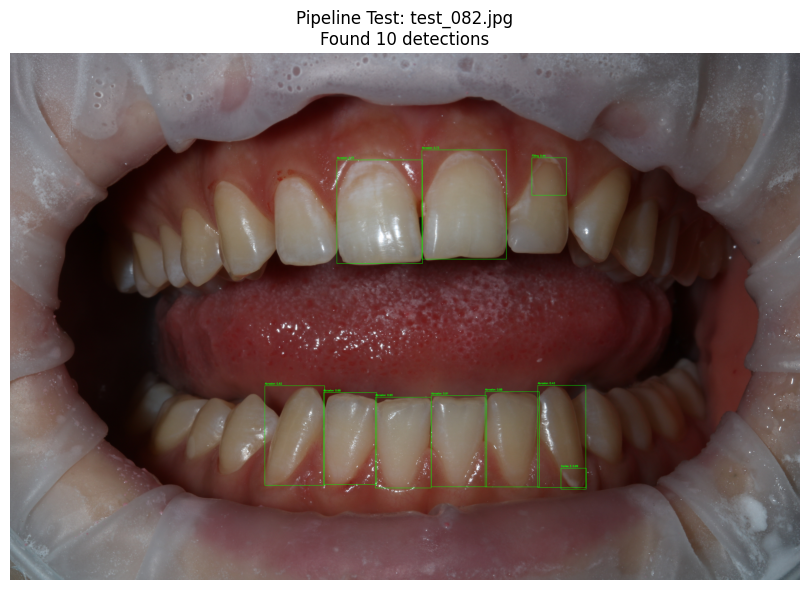


--- Image 2: test_094.jpg ---


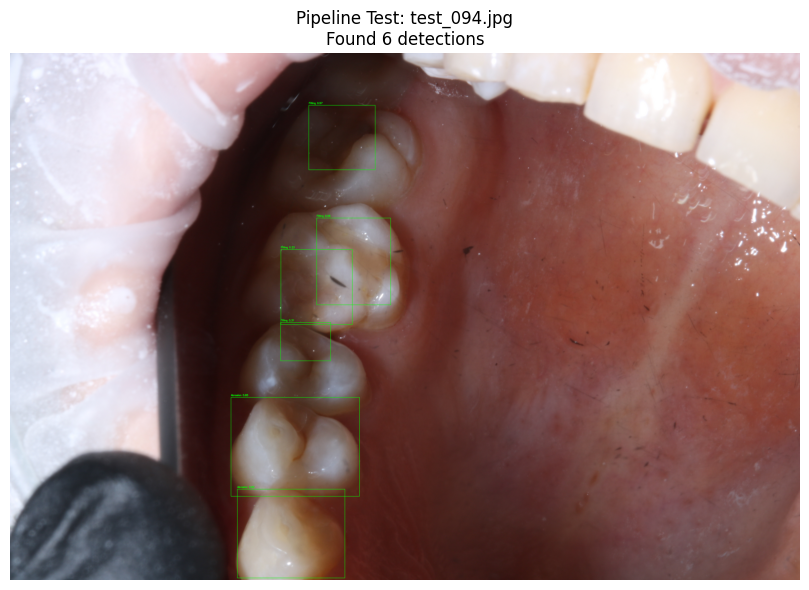


--- Image 3: test_128.jpg ---


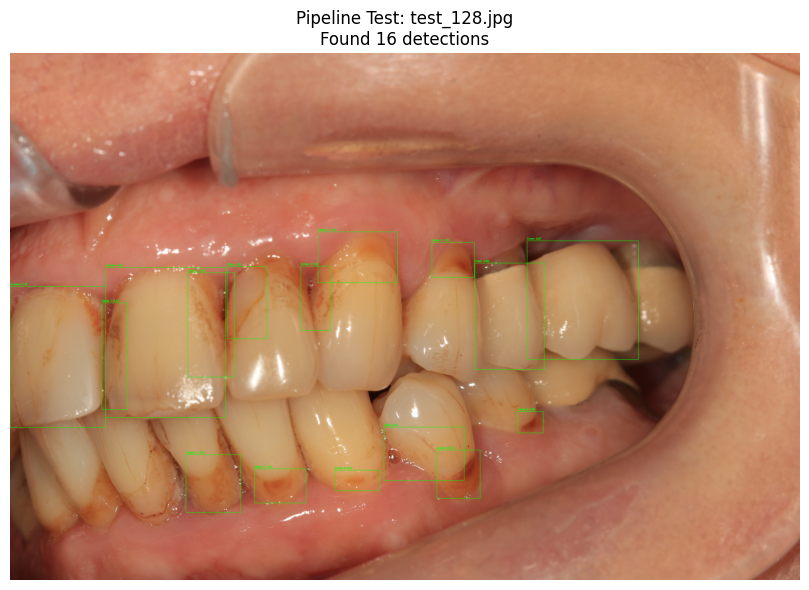

In [35]:
import cv2
import matplotlib.pyplot as plt
from random import sample
import torch
import numpy as np
import os
from PIL import Image
from torchvision import transforms

def test_pipeline_on_random_images(yolo_model, rcnn_model, classifier, image_paths, class_names, num_samples=3, imgsz=640):
    """
    Quick test of the pipeline on a few random images
    """
    # Transform for classifier
    clf_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    
    classifier_cpu = classifier.to("cpu")
    device = next(rcnn_model.parameters()).device
    
    # Pick random images
    random_images = sample(image_paths, min(num_samples, len(image_paths)))
    
    print(f"Testing pipeline on {len(random_images)} random images...")
    
    for idx, img_path in enumerate(random_images):
        print(f"\n--- Image {idx+1}: {os.path.basename(img_path)} ---")
        
        # Step 1: YOLO detection
        yolo_results = yolo_model.predict(
            img_path, imgsz=imgsz, conf=0.25, iou=0.45,
            retina_masks=False, verbose=False
        )
        yolo_result = yolo_results[0]
        
        # Load image
        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        h, w = img_rgb.shape[:2]
        
        if yolo_result.boxes is None or len(yolo_result.boxes) == 0:
            print("❌ No detections found")
            continue
            
        boxes = yolo_result.boxes.xyxy.cpu().numpy()
        yolo_classes = yolo_result.boxes.cls.cpu().numpy().astype(int)
        confidences = yolo_result.boxes.conf.cpu().numpy()
        
        # print(f"✅ YOLO found {len(boxes)} detections")
        
        # Process each detection
        final_results = []
        
        for i, (box, yolo_cls, conf) in enumerate(zip(boxes, yolo_classes, confidences)):
            x1, y1, x2, y2 = box.astype(int)
            
            # print(f"  Detection {i+1}: YOLO class={yolo_cls}, conf={conf:.3f}")
            
            final_cls = int(yolo_cls)
            final_conf = float(conf)
            pipeline_info = f"YOLO: {class_names[yolo_cls]}"
            
            # Step 2: R-CNN refinement
            crop = img_rgb[y1:y2, x1:x2]
            if crop.size > 0:
                crop_pil = Image.fromarray(crop).convert("RGB")
                crop_tensor = transforms.ToTensor()(crop_pil).unsqueeze(0).to(device)
                
                with torch.no_grad():
                    rcnn_outputs = rcnn_model(crop_tensor)
                
                rcnn_result = rcnn_outputs[0]
                if (rcnn_result['scores'] is not None and 
                    len(rcnn_result['scores']) > 0):
                    
                    best_rcnn_conf = rcnn_result['scores'].max().item()
                    # print(f"    R-CNN refinement: conf={best_rcnn_conf:.3f}")
                    pipeline_info += f" → R-CNN: {best_rcnn_conf:.3f}"
            
            # Step 3: Classifier refinement
            if yolo_cls == 3:  # Adjust this condition as needed
                if crop.size > 0:
                    crop_tensor_clf = clf_transform(crop_pil).unsqueeze(0)
                    
                    with torch.no_grad():
                        out = classifier_cpu(crop_tensor_clf)
                        fine_cls = int(out.argmax(1).item())
                        classifier_conf = torch.softmax(out, dim=1).max().item()
                    
                    final_cls = fine_cls + 3  # Adjust mapping as needed
                    final_conf = classifier_conf
                    
                    refined_class_name = class_names[final_cls] if final_cls < len(class_names) else f"Class_{final_cls}"
                    # print(f"    Classifier refinement: {refined_class_name}, conf={classifier_conf:.3f}")
                    pipeline_info += f" → Classifier: {refined_class_name}"
            
            final_results.append({
                'box': box,
                'class': final_cls,
                'confidence': final_conf,
                'pipeline_info': pipeline_info
            })
        
        # Visualize results
        img_display = img_rgb.copy()
        
        for i, result in enumerate(final_results):
            box = result['box']
            x1, y1, x2, y2 = box.astype(int)
            
            # Draw box
            color = (0, 255, 0)  # Green
            cv2.rectangle(img_display, (x1, y1), (x2, y2), color, 2)
            
            # Draw label
            final_class_name = class_names[result['class']] if result['class'] < len(class_names) else f"Class_{result['class']}"
            label = f"{final_class_name} {result['confidence']:.2f}"
            
            cv2.putText(img_display, label, (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        # Show result
        plt.figure(figsize=(10, 6))
        plt.imshow(img_display)
        plt.axis('off')
        plt.title(f"Pipeline Test: {os.path.basename(img_path)}\n"
                 f"Found {len(final_results)} detections")
        plt.tight_layout()
        plt.show()
        
        # Print summary
        # print("Final Results:")
        # for i, result in enumerate(final_results):
        #     final_class_name = class_names[result['class']] if result['class'] < len(class_names) else f"Class_{result['class']}"
        #     print(f"  {i+1}. {final_class_name} (conf: {result['confidence']:.3f})")
        #     print(f"     Pipeline: {result['pipeline_info']}")

# Quick test with 3 random images
test_pipeline_on_random_images(
    yolo_model=yolo_model,
    rcnn_model=rcnn_model, 
    classifier=classifier,
    image_paths=test_images, 
    class_names=[CLASS_INFO[i]['name'] for i in range(9)],
    num_samples=3  # Test on 3 random images
)

# STOP HERE, THE NEXT IS THE OLFER CODE

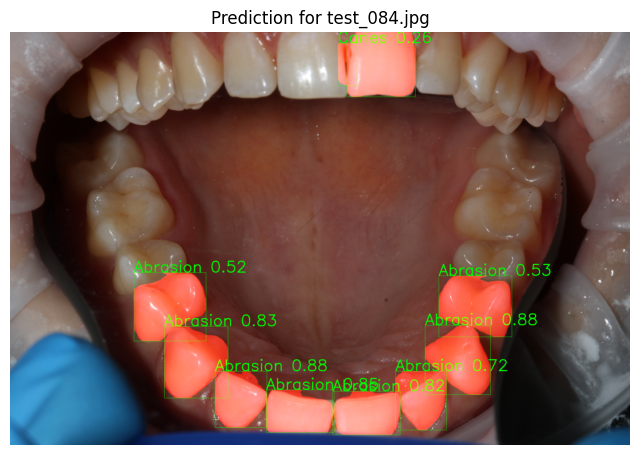

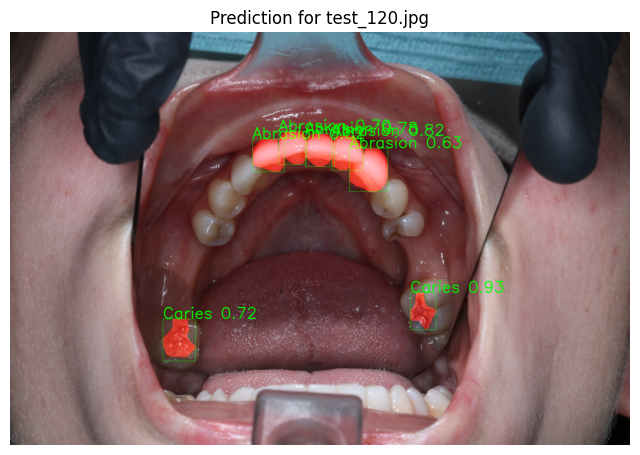

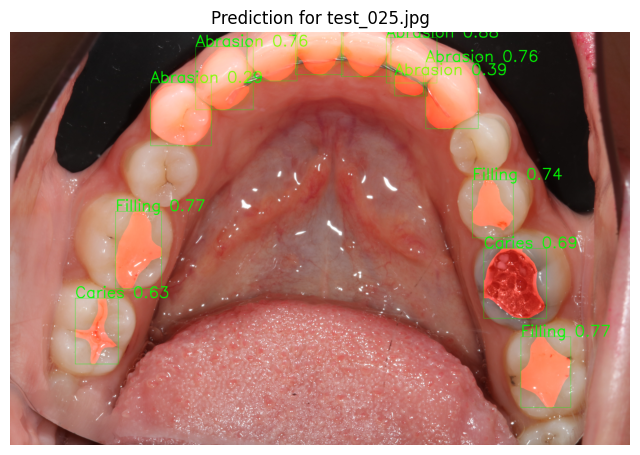

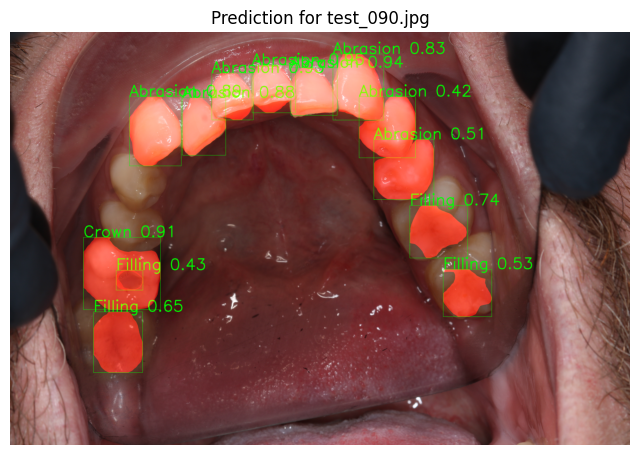

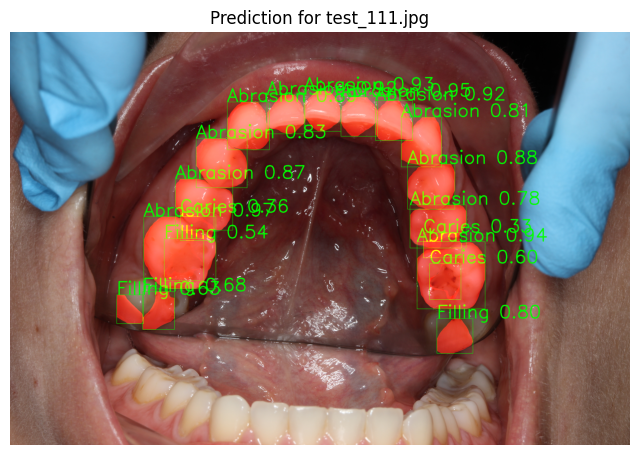

In [21]:
import cv2
import matplotlib.pyplot as plt
from random import sample
import torch

# Function to visualize predictions on images
def visualize_predictions(model, image_paths, class_names, num_samples=5, imgsz=640):
    # Randomly pick some images
    sample_paths = sample(image_paths, min(num_samples, len(image_paths)))

    for img_path in sample_paths:
        # Run prediction on the single image
        results = model.predict(img_path, imgsz=imgsz, conf=0.25, iou=0.45, retina_masks=True, verbose=False)
        result = results[0]

        # Read image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Draw boxes
        if result.boxes is not None and len(result.boxes) > 0:
            boxes = result.boxes.xyxy.cpu().numpy()  # x1, y1, x2, y2
            classes = result.boxes.cls.cpu().numpy().astype(int)
            confidences = result.boxes.conf.cpu().numpy()

            for i, (box, cls, conf) in enumerate(zip(boxes, classes, confidences)):
                x1, y1, x2, y2 = box.astype(int)
                color = (0, 255, 0)  # green box
                cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                label = f"{class_names[cls]} {conf:.2f}"
                # Increase font size
                cv2.putText(
                    img,
                    label,
                    (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=5.0,  # increase from 0.5
                    color=color,
                    thickness=10
                )


        if result.masks is not None and len(result.masks) > 0:
            masks = result.masks.data.cpu().numpy()  # HxW mask
            for mask in masks:
                # Convert mask to binary and apply color overlay
                mask = (mask > 0.5).astype(np.uint8)
                color_mask = np.zeros_like(img)
                color_mask[:, :, 0] = mask * 255  # Red channel
                img = cv2.addWeighted(img, 1.0, color_mask, 0.5, 0)

        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prediction for {os.path.basename(img_path)}")
        plt.show()


visualize_predictions(model, test_images, [CLASS_INFO[i]['name'] for i in range(4)], num_samples=5)

In [22]:
# yolo_model = model

In [23]:
# OUTPUT_DIR = '/kaggle/working/'

# NEW_DATASET_PATH = f'{OUTPUT_DIR}/alphadent_90_10_split'
# NEW_TRAIN_IMAGES_PATH = f'{NEW_DATASET_PATH}/images/train'
# NEW_EVAL_IMAGES_PATH = f'{NEW_DATASET_PATH}/images/eval'
# NEW_VALID_IMAGES_PATH = f'{NEW_DATASET_PATH}/images/valid'
# NEW_TEST_IMAGES_PATH = f'{NEW_DATASET_PATH}/images/test'
# NEW_TRAIN_LABELS_PATH = f'{NEW_DATASET_PATH}/labels/train'
# NEW_EVAL_LABELS_PATH = f'{NEW_DATASET_PATH}/labels/eval'
# NEW_VALID_LABELS_PATH = f'{NEW_DATASET_PATH}/labels/valid'

# Caries Classifier

In [25]:
import os
import cv2
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from glob import glob

# ---------------- Paths & Settings ----------------
TRAIN_PATH = "/kaggle/input/alpha-dent/AlphaDent/images/train"
TRAIN_LABEL_PATH = "/kaggle/input/alpha-dent/AlphaDent/labels/train"
NUM_CLASSES = 6   # caries1 -> caries6
IMG_SIZE = 224    # ResNet input size
BATCH_SIZE = 16
EPOCHS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------- Dataset ----------------
class PolygonCariesDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.samples = []
        self.transform = transform

        image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
        label_paths = sorted(glob(os.path.join(label_dir, "*.txt")))

        for img_path, lbl_path in zip(image_paths, label_paths):
            with open(lbl_path, "r") as f:
                lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                class_id = int(parts[0])
                if 3 <= class_id <= 8:  # merged classes
                    coords = np.array(parts[1:], dtype=float).reshape(-1, 2)
                    self.samples.append((img_path, coords, class_id-3))  # 0-5

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, coords, label = self.samples[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # Crop polygon bounding box
        xs, ys = coords[:,0], coords[:,1]
        x1, y1 = max(int(xs.min()*w),0), max(int(ys.min()*h),0)
        x2, y2 = min(int(xs.max()*w), w-1), min(int(ys.max()*h), h-1)
        crop = img[y1:y2, x1:x2]

        # Convert to PIL and transform
        crop = Image.fromarray(crop).convert("RGB")
        if self.transform:
            crop = self.transform(crop)
        return crop, label

# ---------------- Transforms ----------------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

print("--- Loading Train Dataset ---")
train_dataset = PolygonCariesDataset(TRAIN_PATH, TRAIN_LABEL_PATH, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# ---------------- Model ----------------
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)  # Replace final layer
model = model.to(DEVICE)

# ---------------- Loss & Optimizer ----------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("--- Start Training ---")
# ---------------- Training Loop ----------------
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {running_loss/len(train_loader):.4f} "
          f"Accuracy: {correct/total:.4f}")

# ---------------- Save Model ----------------
torch.save(model.state_dict(), "caries_polygon_classifier.pth")
print("Model saved as caries_polygon_classifier.pth")


--- Loading Train Dataset ---
--- Start Training ---
Epoch [1/5] Loss: 0.7652 Accuracy: 0.7345
Epoch [2/5] Loss: 0.3810 Accuracy: 0.8686
Epoch [3/5] Loss: 0.2332 Accuracy: 0.9171
Epoch [4/5] Loss: 0.1484 Accuracy: 0.9536
Epoch [5/5] Loss: 0.0976 Accuracy: 0.9717
Model saved as caries_polygon_classifier.pth


### Classifier Validation


=== Classification Report ===
              precision    recall  f1-score   support

     caries1       0.74      0.82      0.78        62
     caries2       0.84      0.81      0.83        73
     caries3       0.78      0.64      0.70        33
     caries4       0.00      0.00      0.00         4
     caries5       0.78      0.86      0.82        81
     caries6       0.50      0.20      0.29         5

    accuracy                           0.78       258
   macro avg       0.61      0.56      0.57       258
weighted avg       0.77      0.78      0.77       258



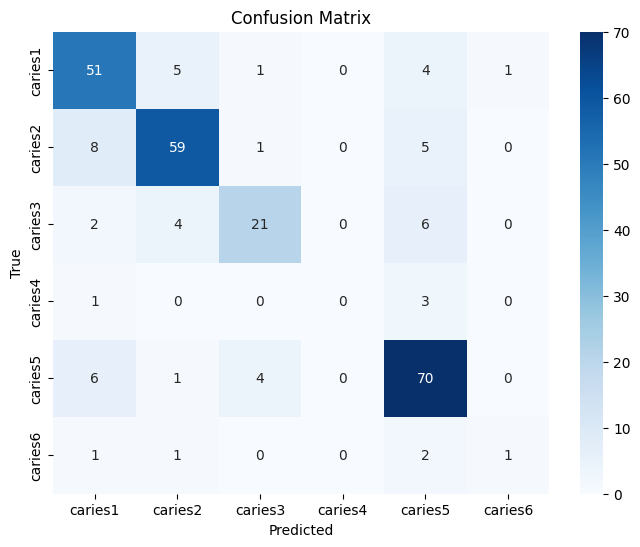

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ---------------- Validation Dataset ----------------
VAL_PATH = "/kaggle/input/alpha-dent/AlphaDent/images/valid"
VAL_LABEL_PATH = "/kaggle/input/alpha-dent/AlphaDent/labels/valid"

val_dataset = PolygonCariesDataset(VAL_PATH, VAL_LABEL_PATH, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ---------------- Evaluation ----------------
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        _, preds = outputs.max(1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# ---------------- Metrics ----------------
print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=[f"caries{i}" for i in range(1, NUM_CLASSES+1)]))

# ---------------- Confusion Matrix ----------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"caries{i}" for i in range(1, NUM_CLASSES+1)],
            yticklabels=[f"caries{i}" for i in range(1, NUM_CLASSES+1)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## Classify Test Dataset

In [38]:
CLASS_INFO = {
    0: {'name': 'Abrasion', 'description': 'Teeth with mechanical wear of hard tissues'},
    1: {'name': 'Filling', 'description': 'Dental fillings of various types'},
    2: {'name': 'Crown', 'description': 'Dental crown (restoration)'},
    3: {'name': 'Caries 1', 'description': 'Caries in fissures and pits (occlusal surfaces of molars/premolars, buccal surfaces of molars, lingual surfaces of upper incisors).'},
    4: {'name': 'Caries 2', 'description': 'Caries on proximal surfaces of molars and premolars.'},
    5: {'name': 'Caries 3', 'description': 'Caries on proximal surfaces of incisors/canines without incisal edge involvement.'},
    6: {'name': 'Caries 4', 'description': 'Caries on proximal surfaces of incisors/canines with incisal edge involvement.'},
    7: {'name': 'Caries 5', 'description': 'Cervical caries (buccal/lingual surfaces).'},
    8: {'name': 'Caries 6', 'description': 'Caries on incisal edges of anterior teeth or cusps of molars.'},
}

In [73]:
# import torch

# print(torch.cuda.device_count())  # should show 2
# print(torch.cuda.get_device_name(0))  # GPU 0
# print(torch.cuda.get_device_name(1))  # GPU 1

torch.cuda.empty_cache()
best_model_path = f'{OUTPUT_DIR}/alphadent_yolov8x_90_10/weights/best.pt'
if os.path.exists(best_model_path):
    yolo_model = YOLO(best_model_path)
    print(f"Loaded best model from: {best_model_path}")

Loaded best model from: /kaggle/working//alphadent_yolov8x_90_10/weights/best.pt


In [75]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision import transforms
from PIL import Image

classifier = model
classifier.load_state_dict(torch.load("caries_polygon_classifier.pth", map_location="cpu"))
classifier.eval()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
yolo_model = yolo_model.to(device)
classifier = classifier.to(device)

# print("Using device:", device, "Name:", torch.cuda.get_device_name(0))

# ----- Transform for classifier -----
clf_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
def predict_and_save(yolo_model, image_paths, class_names, submission_file="final_model_submission.csv", imgsz=640):
    all_preds = []
    row_id = 0

    # YOLO on GPU, classifier on CPU
    classifier_cpu = classifier.to("cpu")

    for img_path in image_paths:
        # YOLO runs normally (uses CUDA)
        results = yolo_model.predict(
            img_path, imgsz=imgsz, conf=0.25, iou=0.45,
            retina_masks=True, verbose=False
        )
        result = results[0]

        h, w = result.orig_shape
        if result.boxes is None or len(result.boxes) == 0:
            continue

        boxes = result.boxes.xyxy.cpu().numpy()
        classes = result.boxes.cls.cpu().numpy().astype(int)
        confidences = result.boxes.conf.cpu().numpy()
        masks_xy = result.masks.xy if result.masks is not None else []

        for i, (box, cls, conf) in enumerate(zip(boxes, classes, confidences)):
            x1, y1, x2, y2 = box.astype(int)

            final_cls = int(cls)

            # Refine "caries merged" class with CPU classifier
            if cls == 3:
                img_bgr = cv2.imread(img_path)
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                crop = img_rgb[y1:y2, x1:x2]

                if crop.size > 0:
                    crop_pil = Image.fromarray(crop).convert("RGB")
                    crop_tensor = clf_transform(crop_pil).unsqueeze(0)  # keep on CPU

                    with torch.no_grad():
                        out = classifier_cpu(crop_tensor)
                        fine_cls = int(out.argmax(1).item())
                    final_cls = fine_cls + 3  # shift to [3–8]

            # polygon normalization
            poly_str = ""
            if i < len(masks_xy):
                polygon = masks_xy[i]
                if polygon is not None and len(polygon) >= 3:
                    normalized_coords = []
                    for point in polygon:
                        x_norm = float(point[0]) / w
                        y_norm = float(point[1]) / h
                        normalized_coords.extend([
                            max(0.0, min(1.0, x_norm)),
                            max(0.0, min(1.0, y_norm))
                        ])
                    poly_str = " ".join([f"{coord:.6f}" for coord in normalized_coords])

            patient_id = os.path.splitext(os.path.basename(img_path))[0]
            all_preds.append({
                "id": row_id,
                "patient_id": patient_id,
                "class_id": final_cls,
                "confidence": float(conf),
                "poly": poly_str
            })
            row_id += 1

    df = pd.DataFrame(all_preds)
    df.to_csv(submission_file, index=False)
    print(f"✅ Submission saved to {submission_file}")


predict_and_save(
    yolo_model=yolo_model,                        # your YOLO model
    image_paths=test_images,                 # list of test images
    class_names=[CLASS_INFO[i]['name'] for i in range(9)],  # 0–8 names
    submission_file="submission.csv"
)

✅ Submission saved to submission.csv


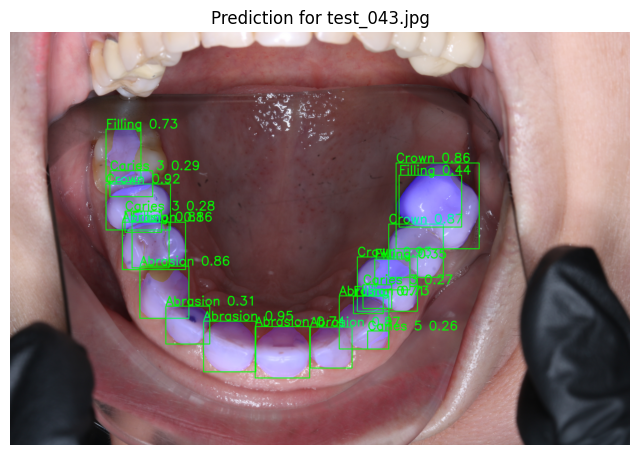

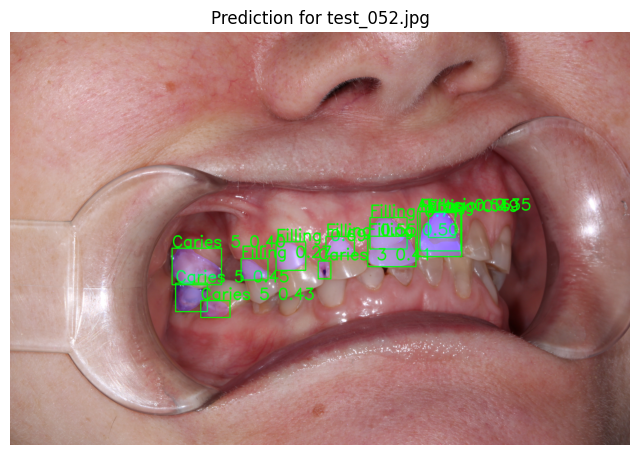

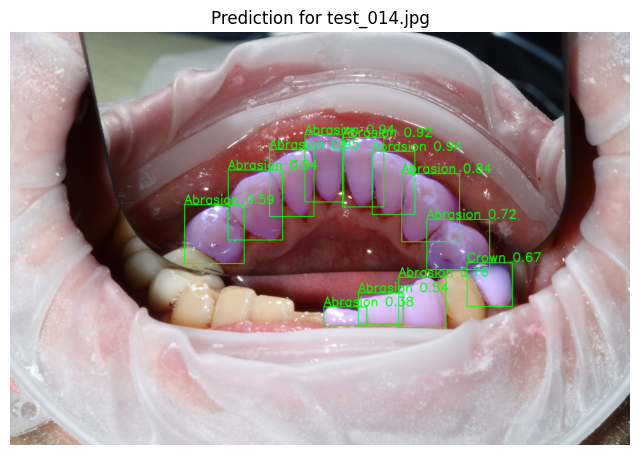

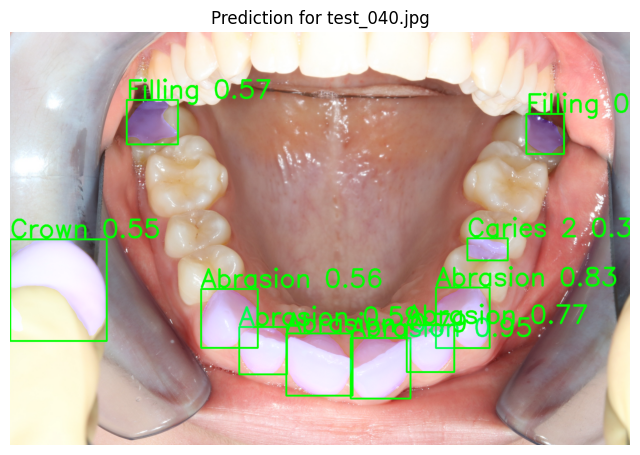

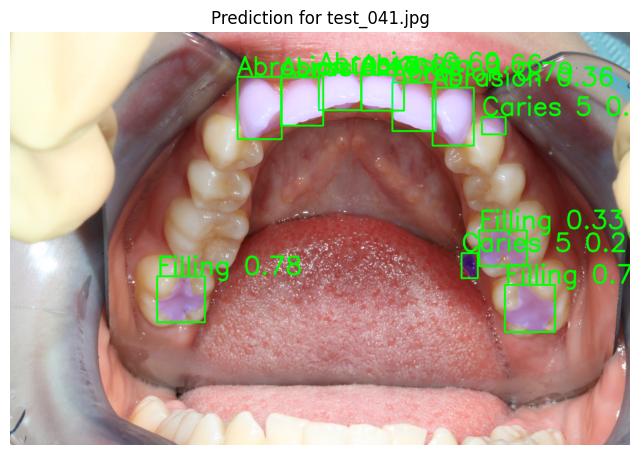

In [99]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import sample
from PIL import Image

def visualize_predictions_with_classifier(
    yolo_model,
    image_paths,
    class_names,
    classifier,
    clf_transform,
    num_samples=5,
    imgsz=640
):
    # Classifier on CPU
    classifier = classifier.to("cpu")
    classifier.eval()

    # Pick sample images
    sample_paths = sample(image_paths, min(num_samples, len(image_paths)))

    for img_path in sample_paths:
        # Run YOLO prediction
        results = yolo_model.predict(
            img_path,
            imgsz=imgsz,
            conf=0.25,
            iou=0.45,
            retina_masks=True,
            verbose=False
        )
        result = results[0]

        # Read image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if result.boxes is not None and len(result.boxes) > 0:
            boxes = result.boxes.xyxy.cpu().numpy()
            classes = result.boxes.cls.cpu().numpy().astype(int)
            confidences = result.boxes.conf.cpu().numpy()

            for i, (box, cls, conf) in enumerate(zip(boxes, classes, confidences)):
                x1, y1, x2, y2 = box.astype(int)

                # Extract mask (if available)
                mask_overlay = None
                if result.masks is not None and len(result.masks.data) > i:
                    mask = result.masks.data[i].cpu().numpy()
                    mask = (mask > 0.5).astype(np.uint8) * 255
                    mask_overlay = cv2.resize(mask, (img.shape[1], img.shape[0]))

                # Fine classification if class == 3
                if cls == 3:
                    crop = img[y1:y2, x1:x2]
                    if crop.size > 0:
                        crop_pil = Image.fromarray(crop).convert("RGB")
                        crop_tensor = clf_transform(crop_pil).unsqueeze(0)  # CPU only
                        with torch.inference_mode():
                            pred = classifier(crop_tensor)
                            fine_cls = pred.argmax(1).item()
                        cls = fine_cls + 3

                # Overlay mask with transparency
                if mask_overlay is not None:
                    color_mask = np.zeros_like(img, dtype=np.uint8)
                    color_mask[:, :] = (0, 0, 200)  # green mask
                    img = cv2.addWeighted(
                        img, 1.0, cv2.bitwise_and(color_mask, color_mask, mask=mask_overlay), 0.4, 0
                    )
                
                # Draw bounding box (thicker)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 8)
                
                # Label (larger font + thicker text)
                label = f"{class_names[cls]} {conf:.2f}"
                cv2.putText(
                    img, label, (x1, max(30, y1 - 10)),   # shift a bit higher
                    cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=4,    # larger text
                    color=(0, 255, 0),
                    thickness=10,      # thicker border
                    lineType=cv2.LINE_AA
                )


        # Show final image
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prediction for {os.path.basename(img_path)}")
        plt.show()


visualize_predictions_with_classifier(
    yolo_model=yolo_model,
    image_paths=test_images,
    class_names=[CLASS_INFO[i]['name'] for i in range(9)],  # 0–8 names
    classifier=classifier,   # your trained classifier
    clf_transform=clf_transform,
    num_samples=5
)
